# Artistic Style Transfer with Deep Learning

This notebook demonstrates the process of creating a deep learning model that can transfer the artistic style of one image to the content of another image. We use Convolutional Neural Networks (CNNs) to extract style and content features and recombine them to create a new, stylized image.

The process consists of the following steps:
1. Load and preprocess the content and style images.
2. Define and build the style transfer model.
3. Set up loss functions that measure how well we're achieving our goals.
4. Train the model to minimize these losses.
5. Evaluate the results and iterate to improve the quality of the stylized image.


In [36]:
# Importing necessary libraries
import os
import tensorflow as tf
print(tf.__version__)  # Display the version of TensorFlow to ensure compatibility
import matplotlib.pyplot as plt  # For plotting images
import numpy as np
from PIL import Image  # For image manipulation
import time
import functools  # For function utilities

2.14.0


In [2]:
# Check if a GPU is available
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
    print('GPU device not found. Make sure to change the runtime type to GPU.')
else:
    print('Found GPU at: {}'.format(device))

'/device:GPU:0'

## Image Loading and Preprocessing

Before we can perform style transfer, we need to load and preprocess our content and style images. This involves resizing the images to a consistent size and normalizing the pixel values.


In [3]:
def load_image(image_path):
    # Define the maximum dimension to scale images to
    max_dim = 512
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image as a JPEG file and ensure 3 color channels
    image = tf.image.decode_jpeg(image, channels=3)
    # Normalize the image pixels to the range [0,1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Get the shape of the image, excluding the channel dimension
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    # Find the longest dimension and calculate the scaling factor
    long_dim = tf.reduce_max(shape)
    scale = max_dim / long_dim
    # Calculate the new shape with the scaling factor applied
    new_shape = tf.cast(shape * scale, tf.int32)

    # Resize the image to the new shape
    image = tf.image.resize(image, new_shape)
    # Add a batch dimension for model processing
    image = image[tf.newaxis, :]
    return image


## Displaying Images

To visually inspect our content and style images, we have defined a utility function `imshow` that simplifies the image display process. This function handles images with an extra batch dimension that TensorFlow often requires by squeezing that dimension away. It then uses `matplotlib` to display the image, optionally with a title.

Following the definition, we load our content and style images using the previously defined `load_image` function. We then display their shapes to verify that they have been processed correctly into tensors with the expected dimensions.

Finally, we plot the content and style images side-by-side for a visual comparison. This helps us understand the original content that will be preserved and the artistic style that will be transferred.


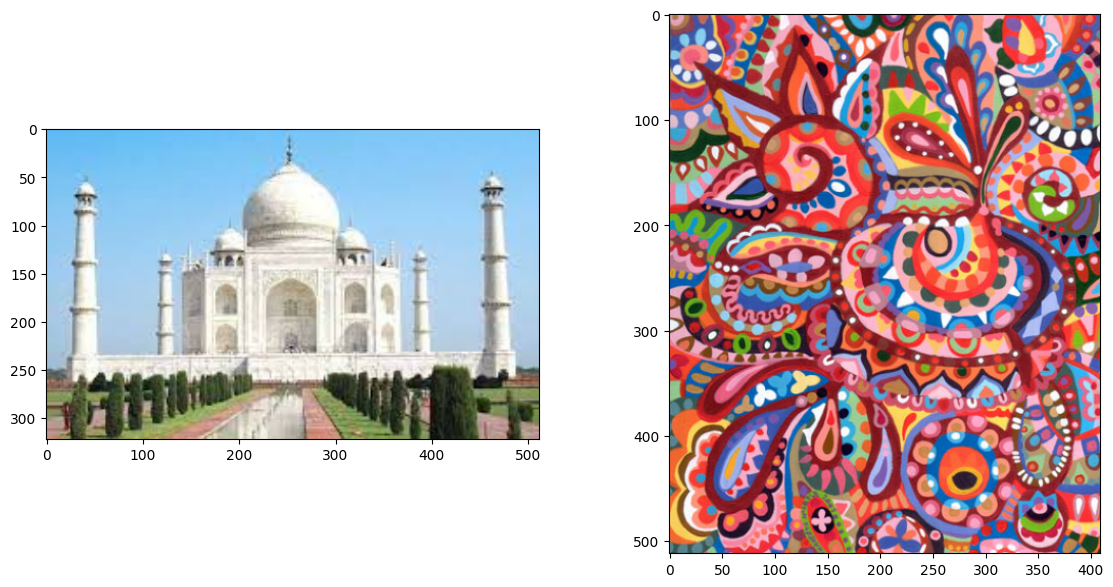

In [7]:
def imshow(image, title=None):
    # Remove the batch dimension if present by squeezing if the image has 4 dimensions
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)  # Display the image using matplotlib
    if title:
        plt.title(title)  # Set the title of the plot if provided

# Load the content and style images using the predefined function
content_image = load_image(content_path)
style_image = load_image(style_path)

# Print out the shapes of the content and style images to ensure they are correct
print(content_image.shape, style_image.shape)  # Expected output: (1, 322, 512, 3) (1, 512, 409, 3)

# Set up the figure size for plotting
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)  # Prepare a subplot for the content image
imshow(content_image)  # Display the content image using the imshow function

plt.subplot(1, 2, 2)  # Prepare a subplot for the style image
imshow(style_image)  # Display the style image using the imshow function


In [6]:
content_image = load_image(content_path)
style_image = load_image(style_path)
print(content_image.shape, style_image.shape)

(1, 322, 512, 3) (1, 512, 409, 3)


# Neural Style Transfer with VGG19

In this section, we prepare the VGG19 model, which is pivotal for the feature extraction in neural style transfer. The VGG19 model is well-known for its effectiveness in image classification and is also commonly used for extracting features from images for style transfer tasks.

## Image Preprocessing for VGG19

Before we can use the content image in the VGG19 model, we need to preprocess it. This involves resizing the image to the input size expected by the model and scaling the pixel values.


In [8]:
# Preprocess the image to fit VGG19 expected input, scaling the pixel values
x = tf.keras.applications.vgg19.preprocess_input(content_image * 255)
# Resize the image to the size (224, 224) for VGG19
x = tf.image.resize(x, (224, 224))
# Check the shape of the processed image, should be (1, 224, 224, 3)
print(x.shape)

TensorShape([1, 224, 224, 3])

In [9]:
# Load the VGG19 model with weights pre-trained on ImageNet and without the top classification layer
vgg = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
# Display the summary of the VGG19 model to show its architecture
vgg.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [10]:
# Print the names of the layers in the VGG19 model
for layer in vgg.layers:
     print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [11]:
# Define the layers to be used for content and style extraction
content_layer = ["block5_conv2"]
style_layers = ["block1_conv1",
             "block2_conv1",
             "block3_conv1",
             "block4_conv1",
             "block5_conv1"]
# Count the number of layers used for content and style extraction
num_content_layers = len(content_layer)
num_style_layers = len(style_layers)

In [12]:
# Function to create a model that returns the output of the specified layers
def vgg_layers(layer_names):
    # Load the VGG19 model with pre-trained ImageNet weights
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    # Set the VGG19 model to be non-trainable
    vgg.trainable = False
    # Get the outputs of the specified layers
    outputs = [vgg.get_layer(name).output for name in layer_names]
    # Create a new model that takes the same input as VGG19 but outputs the content and style layers
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [13]:
# Use the function to get a model that outputs the style layers
style_extractor = vgg_layers(style_layers)
# Pass the style image through this model to get the style features
style_outputs = style_extractor(style_image * 255)

In [14]:
# Print the shape and statistics of the style features
for i in style_outputs:
    print(i.shape)

(1, 512, 409, 64)
(1, 256, 204, 128)
(1, 128, 102, 256)
(1, 64, 51, 512)
(1, 32, 25, 512)


In [15]:
# Print the shape and statistics of the style features
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("shape", output.numpy().shape)
    print("min", output.numpy().min())
    print("max", output.numpy().max())
    print("mean", output.numpy().mean())
    print()

block1_conv1
shape (1, 512, 409, 64)
min 0.0
max 865.0305
mean 41.767925

block2_conv1
shape (1, 256, 204, 128)
min 0.0
max 5261.956
mean 241.98782

block3_conv1
shape (1, 128, 102, 256)
min 0.0
max 10029.242
mean 321.6172

block4_conv1
shape (1, 64, 51, 512)
min 0.0
max 27333.762
mean 937.41833

block5_conv1
shape (1, 32, 25, 512)
min 0.0
max 3375.8777
mean 59.205345



### Defining the gram matrix function, which is used to calculate the style loss later on


In [16]:
def gram_matrix(input_tensor):
    # Using 'tf.linalg.einsum' to compute the gram matrix of the input tensor
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    # Normalizing the gram matrix by the number of locations
    return result / num_locations


In [17]:
# Defining the model class for style and content
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.num_content_layers = len(content_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        # Scale inputs to range expected by VGG
        inputs = inputs * 255.0
        # Preprocess the inputs
        preprocess_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        # Pass it through the model
        outputs = self.vgg(preprocess_input)
        # Separate style and content features
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        # Calculate the gram matrix for each style layer
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        # Reformat the content and style outputs as dictionaries
        content_dict = {content_name:value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        # Return the style and content dictionaries
        return {'content': content_dict, 'style': style_dict}

In [18]:
# Instantiate the style and content model
extractor = StyleContentModel(style_layers, content_layer)
# Pass the content image through the model to get the style and content features
result = extractor(tf.constant(content_image))

print("Styles: ")
for name, output in sorted(result["style"].items()):
    print("", name)
    print("shape:", output.numpy().shape)
    print("min:", output.numpy().min())
    print("max:", output.numpy().max())
    print("mean:", output.numpy().mean())
    print()

Styles: 
 block1_conv1
shape: (1, 64, 64)
min: 0.018663764
max: 73846.26
mean: 640.1429

 block2_conv1
shape: (1, 128, 128)
min: 0.0
max: 86316.65
mean: 14021.672

 block3_conv1
shape: (1, 256, 256)
min: 0.0
max: 342559.22
mean: 12162.819

 block4_conv1
shape: (1, 512, 512)
min: 0.0
max: 2905034.0
mean: 180332.17

 block5_conv1
shape: (1, 512, 512)
min: 0.0
max: 286154.88
mean: 2204.1604



In [19]:
for name, output in sorted(result["content"].items()):
    print("", name)
    print("shape:", output.numpy().shape)
    print("min:", output.numpy().min())
    print("max:", output.numpy().max())
    print("mean:", output.numpy().mean())
    print()


 block5_conv2
shape: (1, 20, 32, 512)
min: 0.0
max: 1599.3916
mean: 17.292233



## Defining Style and Content Targets

The first step in our style transfer process is to define what our targets are. For style, we extract features from our style image using our model; these serve as our style targets. Similarly, we also extract content features from our content image to use as our content targets. These targets will gu


In [20]:
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

## Visualizing the Style Features

To get a sense of what the style features look like, we visualize one of the feature maps. Here we choose the 'block5_conv1' layer's feature map from the style targets and display it using `matplotlib`. This gives us an insight into the textures and patterns that the model has captured from the style image.


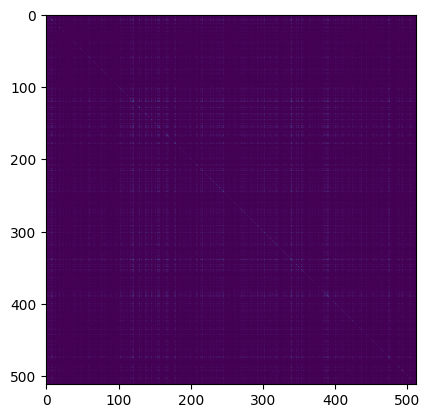

In [21]:
plt.imshow(style_targets["block5_conv1"].numpy()[0])

In [22]:
image = tf.Variable(content_image)

## Preparing for Training

To prepare our content image for style transfer, we convert it into a TensorFlow variable. This allows us to update the image as we optimize our style transfer.

We also define a function `clip_0_1` to keep our image values between 0 and 1, as this is the valid range of pixel values for an image.

The optimizer is set up using the Adam optimizer, which is a common choice for this kind of task. The style and content weights are defined to balance the importance of style and content in our final image.

The `style_content_loss` function computes the loss for both style and content. This function will be used to guide the optimization process.


In [23]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max= 1.0)

In [24]:
optim = tf.optimizers.Adam(learning_rate=0.01, beta_1= 0.99,epsilon = 1e-1)

In [25]:
style_weight = 1e-2
content_weight = 1e4

In [26]:
def style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers):
    style_outputs = outputs["style"]
    content_outputs = outputs["content"]

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss


In [27]:
@tf.function
def train_step(image, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers)
    grad = tape.gradient(loss, image)
    optim.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [28]:
for i in range(4):
    train_step(image, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers)



In [29]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)


In [30]:
from IPython import display


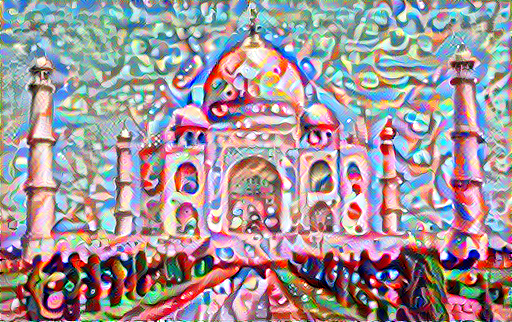

In [31]:
epochs =
steps_per_epoch = 100

for epoch in range(epochs):
    for step in range(steps_per_epoch):
        train_step(image, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers)

    print(epoch)


    display.clear_output(wait=True)
    display.display(tensor_to_image(image))

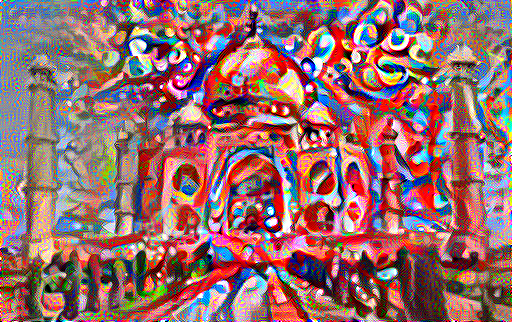

In [35]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# Training loop with early stopping
epochs = 100
steps_per_epoch = 100

for epoch in range(epochs):
    for step in range(steps_per_epoch):
        train_step(image, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers)

    # Display the progress
    print(f"Epoch: {epoch + 1}/{epochs}")
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))

    # Check for early stopping
    if early_stopping.stopped_epoch > 0:
        print("Early stopping triggered. Training stopped.")
        break


## Limitations and Potential Improvements

### Limitations

While the model can produce impressive results, it is not without limitations:

1. **High Resource Consumption**: Neural style transfer is computationally intensive and can require significant memory and processing power, especially for high-resolution images.
2. **Balance of Style and Content**: Finding the right balance between style and content weights can be challenging and may require a lot of manual tuning.
3. **Generalization**: The model may not generalize well across all types of content and style images, with varying levels of success depending on the complexity and contrast of the images used.
4. **Stylization Artifacts**: The model may introduce unwanted artifacts or distortions, particularly if the style image has strong, distinctive features.
5. **Lack of Semantic Understanding**: The model lacks semantic understanding of the images, which can lead to less meaningful style transfers where the context of the content image is not preserved in a stylistically coherent manner.

### Potential Improvements

To overcome these limitations, the following improvements could be considered:

1. **Model Optimization**: Implementing model pruning and quantization techniques could reduce resource consumption and enable the use of the model on devices with limited computational power.
2. **Automated Weight Adjustment**: Machine learning techniques could be applied to automatically adjust the style and content weights based on the images, potentially using reinforcement learning or Bayesian optimization.
3. **Enhanced Generalization**: Training the model on a more diverse dataset, or implementing domain adaptation techniques, could improve its ability to generalize across different styles and content.
4. **Reducing Artifacts**: Incorporating additional loss functions that penalize stylization artifacts or using post-processing techniques could improve the visual quality of the output images.
5. **Semantic Segmentation**: Integrating semantic segmentation could help the model understand the context of different parts of the content image and apply style in a way that is semantically appropriate, leading to more meaningful transfers.

By addressing these limitations, the model can be made more robust and versatile, capable of producing high-quality style transfers across a wide range of styles and content images.
